In [1]:
# Modules
import numpy as np
import matplotlib.pyplot as plt # for plotting
from scipy.special import erf, erfinv
import scipy.integrate as integrate
import astropy.units as u # manages units
from astropy.constants import sigma_sb, h, R_sun

from EUV_flux import planck_law

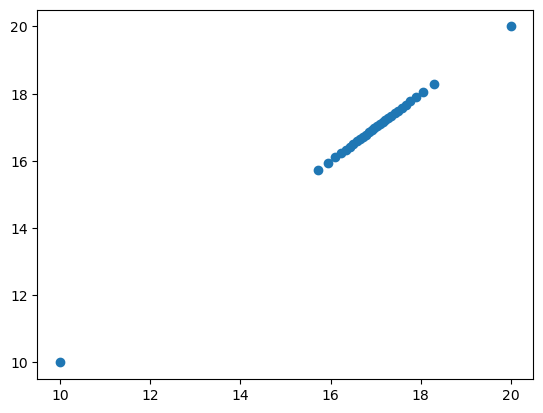

In [2]:
def gspace(start, stop, num=50, A=1, p=0.5):
    """Return numbers spaced evenly in erf^-1(x). This will concentrate most points around a value at a percentage p of the interval to the endpoint.

    Parameters
    ----------
    start : _type_
        Starting value of the samples
    stop : _type_
        Last value of the samples
    num : int, optional
        Number of samples to generate, by default 50
    A : int, optional
        Tunable to determine the spread of points, by default 1
    p : float, optional
        Between 0 and 1, determines where in the interval most points be concentrated, by default 0.5

    Returns
    -------
    samples : ndarray
        `num` samples, equally spaced on an erf scale.
    """
    delta = stop - start
    center = start + p*delta
    a = erf(A*(start - center)/delta)
    b = erf(A*(stop - center)/delta)

    y = np.linspace(a, b, num)

    arr = erfinv(y)*delta/A + center

    arr[0] = start
    arr[-1] = stop

    return arr

# Test:
arr = gspace(10, 20, 30, 10, 0.7)
plt.scatter(arr, arr)


## Ionisation rate
$$n_{H}\Gamma$$
with:
$$\Gamma = \int_{13.6}^{\infty}\frac{L_{\nu} e^{-\tau_{\nu}}}{h\nu} \frac{\sigma_{\nu}}{4\pi d^2} d\nu$$

$\sigma_{\nu}$ is the photoionisation cross-section

$n_H$ Hydrogen number density

$\tau_{\nu} = \int n_{H1} \sigma_{\nu} dr$ is the optical depth

$d$ distance from radiation source

$\frac{L_{\nu}}{h\nu}$ is the photon flux per frequency in the interval $[\nu, \nu + d\nu]$

In [3]:
def sigma_nu(nu):
    """Photoionisation cross section for hydrogen approximated as a power law nu^-3.

    Parameters
    ----------
    nu : float
        Frequency of incoming radiation

    Returns
    -------
    float
        The photoionisation cross section for hydrogen for frequency nu
    """
    nu_0 = (13.6 * u.eV)/h
    sigma_nu_0 = 6.33e-18 * u.cm**2 # from https://w.astro.berkeley.edu/~ay216/06/NOTES/ay216_2006_04_HII.pdf
    return sigma_nu_0 * (nu_0/nu)**3

## Ionisation-recombiantion balance
$$n_{H}\Gamma = n_e n_p \alpha_B$$

$n_H$, $n_e$, $n_p$ Hydrogen, electron and proton number densities

æ alpha from Owen and Alvare 2016 2.6*10^-13 cm^3/s . 

## In our case

$X = \frac{n_e}{n_H}$ ionisation fraction

$n_{HI} = (1 - X) n_H$ number density of non-ionized hydrogen

Then ionisation-recombination balance becomes

$$(1 - X)n_H\Gamma = X^2 n_H^2 \alpha_B$$

assuming $n_p = n_e$

At fixed distance from a star $\Gamma$, $n_H$ and $\alpha_B$ are constant, solving for X:

$$X = \frac{-\Gamma \pm \sqrt{\Gamma^2 + 4n_H\alpha_B\Gamma}}{2n_H\alpha_B}$$

Where only the positive solution is physical.

Alternatively:
the equation can be written as $$(1 - X) = AX^2 $$
with $A = \frac{n_H \alpha_B}{\Gamma}$
so the solution is:
$$X = \frac{-1 + \sqrt{1 + 4A}}{2A}$$
which is of course equivalent to the above.

In [4]:
def ionisation_fraction(gamma, n_H, alpha_B, debug = False):
    """Calculate ionisation fraction by solving recombination-ionisation balance.

    Parameters
    ----------
    gamma : float
        Ionisation rate per photon
    n_H : float
        Hydrogen number density
    alpha_B : float
        Recombination coefficient for case B "on the spot" recombination.
    debug : bool
        Debug flag to enable checks for physical result.

    Returns
    -------
    float
        The plus solution. Checks if is physical, in the interval [0, 1].
    """
    den = 2*n_H*alpha_B
    dis = gamma**2 + 2*den*gamma
    X = (-gamma + np.sqrt(dis)) / den

    if debug:
        if 0 < X and X < 1:
            return X
        else:
            raise(BaseException("Non physical solution! Value obtained: %f"%(X)))
    
    return X

In [5]:
def ionisation_fraction(gamma, n_H, alpha_B, debug = False):
    """Calculate ionisation fraction by solving recombination-ionisation balance.

    Parameters
    ----------
    gamma : float
        Ionisation rate per photon
    n_H : float
        Hydrogen number density
    alpha_B : float
        Recombination coefficient for case B "on the spot" recombination.
    debug : bool
        Debug flag to enable checks for physical result.

    Returns
    -------
    float
        The plus solution. Checks if is physical, in the interval [0, 1].
    """
    A = (n_H*alpha_B)/gamma
    A = np.maximum(A, 1e-5)
    X = (np.sqrt(1 + 4*A) - 1) / (2*A)

    if debug:
        if 0 < X and X < 1:
            return X
        else:
            raise(BaseException("Non physical solution! Value obtained: " + str(X)))
    
    return X

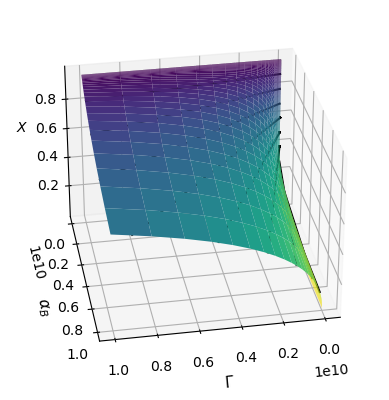

In [6]:
# Test out for a range of values:
x = np.logspace(1, 10, 100)
G, A = np.meshgrid(x, x)
n_H = 1
X = ionisation_fraction(G, 1, A)

# Initialise 3D plot
ax = plt.axes(projection='3d')
# Plot the function of two variables
ax.plot_surface(G, A, X, rstride=1, cstride=1,cmap='viridis_r', edgecolor = 'none')

# Add contour lines
ax.contour(G, A, X, 10, colors = "k", linestyles="solid")

# Plot formatting
ax.set_xlabel(r'$\Gamma$', fontsize = 11)
ax.set_ylabel(r'$\alpha_B$', fontsize = 11)
ax.set_zlabel(r'$X$', fontsize = 10)

ax.azim = 80
ax.dist = 10
ax.elev = 30

For any constant $\alpha_B$, $X \rightarrow 0$ as $\Gamma \rightarrow 0$. This will be important for later, as $\alpha_B$ can be considered constant outside of the ionisation front, while $\Gamma$ will go to zero as density increases.

## Test:
- Solve 0D problem for 1 frequency
- Solve Strömgren sphere for 1 frequency around 13.6eV (does it give a reasonable estimate for the radius?)
- Find Strömgren sphere radius (all frequencies)

## Solve 0D problem
The 0D problem consists of one single radial bin with constant $\alpha_B$, $n_H$, $\sigma_\nu$. Take $\tau_\nu = 1$, $X^0 = 1$, evaluate $\Gamma^0_\nu$ and find $X^1$.

$$L_{tot} = \int_{13.6}^\infty L_\nu d\nu$$
Assume all luminosity from frequency $h\nu_m = 20eV$: 
$$L_\nu = \delta(\nu_m - \nu) L_{tot}$$
So: 
$$ \Gamma_{\nu_m} = \frac{L_{tot}e^{-\tau_{\nu_m}}}{h \nu_m} \frac{\sigma_{\nu_m }}{4\pi r^2}$$
Plug in in formula for $X$ to find the ionisation fraction:
$$X = \frac{-\Gamma \pm \sqrt{\Gamma^2 + 4n_H\alpha_B\Gamma}}{2n_H\alpha_B}$$


In [7]:
# Values needed:
nu_0 = (20 * u.eV)/h
s_nu = sigma_nu(nu_0)
alpha_B = 2.6e-13 * (u.cm **3)/u.s # cm3s-1 at (T = 10^4 K) From Owen and Alvarez 2016
# Number density for Strömgren Sphere
n_H = 8e7 * u.m**(-3) # Nebular density, from Strömgren Sphere PS question

## Single frequency 1D
Take $h\nu_m = 20eV$
- Divide radially into log-spaced bins $[r^0, ..., r^i, ... r^n]$
- Start:
    - Take $X^0 = 1$
    - Take $\tau_\nu^0 = 0$ 
    - Find $\Gamma^0$
    - Find $X^1$
- Iterate:
    - Find $\tau_\nu^{i+1} = \tau_\nu^i +  n_{H} \sigma_{\nu_0} (1-X^i)(r^{i+1} - r^i)$
    - Find $\Gamma^{i+1} = \Gamma^{0} e^{-\tau^{i+1}} \frac{r_0^2}{r_{i+1}^2}$
    - Finx $X^{i+1} = \frac{-\Gamma^{i+1} \pm \sqrt{{\Gamma^{i+1}}^2 + 4n_H\alpha_B\Gamma^{i+1}}}{2n_H\alpha_B}$
    - Repeat until $X^n$

Incoming flux comes from the Stefan-Boltzmann law (multiple frequencies)

Table of Temperatures and expected radii for different spectral types: (from Strömgren spheres PS question)

![](img/SpectralTypes.png)

/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


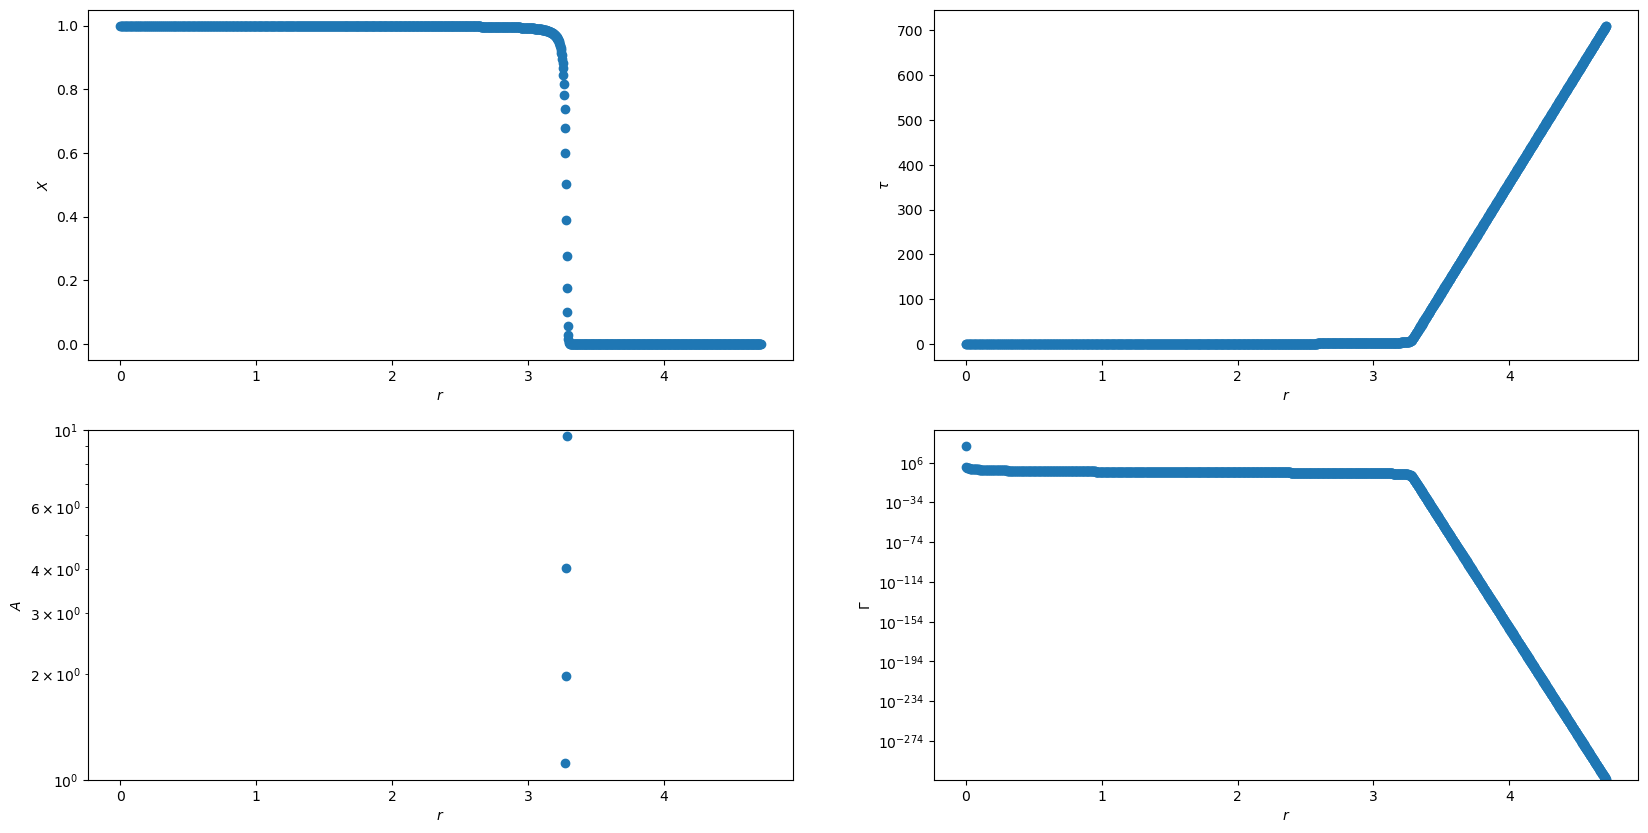

In [8]:
T = np.array([3.5, 3, 2.4, 2.2]) * 1e4 * u.K # array of temperatures for different spectral types 
Q = np.array([5e49, 7e48, 8e47, 1e46]) / u.s # photon flux from star
R_expected = np.array([6.8, 3.5, 1.7, 0.4]) # parsec
a = 1 # select which spectral type to consider
n_bins = 1600 # bin number
r_s = 1e-5 * R_sun # 12 solar radii for main sequence type 05 star http://astro.vaporia.com/start/o5.html
L_tot = h*nu_0*Q[a]

r_min = r_s.to("parsec").value
r_max = (1.5)*R_expected[a]
#r = np.logspace(np.log10(r_min), np.log10(r_max), n_bins) # radial bins
#r = (r_max - r_min - r) * u.parsec # logarithmically space in the other direction and add units
#r = np.abs(np.flip(r)) # value close to 0 can be negative because of rounding errors
r = gspace(r_min, r_max, n_bins, 1, 1.2*R_expected[a]/r_max) * u.parsec


# Initialise starting values:
gamma_0 = s_nu*L_tot/(h*nu_0) * 1/(4*np.pi*r_s**2)

gamma = gamma_0 * np.ones(n_bins)
X = np.ones(n_bins)
A = np.zeros(n_bins)
tau = np.zeros(n_bins)

for i in range(len(r) - 1):
    tau[i+1] = tau[i] + (n_H*s_nu*(1 - X[i])*(r[i+1] - r[i]))
    gamma[i+1] *= np.exp(-tau[i+1])*((r_s/r[i+1])**2)
    A[i+1] = n_H*alpha_B/gamma[i+1]
    X[i+1] = ionisation_fraction(gamma[i+1], n_H, alpha_B, debug = False)

plt.figure(figsize = (20, 10))

plt.subplot(2, 2, 1)
plt.scatter(r, X)
plt.xlabel(r"$r$")
plt.ylabel(r"$X$")

plt.subplot(2, 2, 2)
plt.scatter(r, tau)
plt.xlabel(r"$r$")
plt.ylabel(r"$\tau$")

plt.subplot(2, 2, 3)
plt.scatter(r, A)
plt.xlabel(r"$r$")
plt.ylabel(r"$A$")
plt.yscale("log")

plt.subplot(2, 2, 4)
plt.scatter(r, gamma)
plt.xlabel(r"$r$")
plt.ylabel(r"$\Gamma$")
plt.yscale("log")

In [9]:
print(min(r[X < 1e-1]))
expected_r = (3*Q[a]/(4*np.pi*(n_H**2)*alpha_B))**(1/3)
print(expected_r.to("parsec"))

3.290073578250719 pc
3.245399446049575 pc


## All frequencies
- Divide radially into log-spaced bins $[r^0, ..., r^i, ... r^n]$
- Take $X^0 = 1$
- Take $\tau_\nu^0 = 0$ 
- Find $\Gamma^0$
- Find $X^1$ by applying ionisation-recombination balance
- Find $\tau_\nu^{i+1} = \tau_\nu^i +  n_{H} \sigma_{\nu_0} (1-X^i)(r^{i+1} - r^i)$
- Find $\Gamma^{i+1} = \int_{13.6}^{\infty}\frac{L_{\nu} e^{-\tau_{\nu}^{i+1}}}{h\nu} \frac{\sigma_{\nu}}{4\pi r^2} d\nu$
- Find $A^{i+1} = \frac{n_H \alpha_B}{\Gamma^{i+1}}$
- Finx $X^{i+1} = \frac{-1 + \sqrt{1+4A^{i+1}}}{2A^{i+1}}$
- Repeat until $X^n$

In [10]:
def top_hat(x, a):
    """Top hat function with width a centered at 0.

    Parameters
    ----------
    x : float
        Input of the function
    a : float
        Width of the top hat

    Returns
    -------
    float
        Returns 0 if x is greater than a/2 or less than -a/2, 1 otherwise.
    """
    return np.heaviside(x - a/2, 1)*np.heaviside(a/2 - x, 1)

def fake_delta(x, x0, dx, area):
    """Discrete delta function for numerical integration.

    Parameters
    ----------
    x : float
        Function input.
    x0 : float
        Shift of the peak away from 0.
    dx : float
        The discrete difference over which the integration is taking place. Having a top hat width smaller than this will cause all the integral to be 0.
    area : float
        The total integral of the delta function. The normalisation is determined so that integrating the delta function gives this value.

    Returns
    -------
    Float
        Returns 0 if |x - x0| is greater than dx/2 or less than -dx/2, area/dx otherwise.
    """
    h = area/dx # find height so that integral is equal to the desired area
    return h*top_hat(x - x0, dx)

7e+48 1 / s 2.934953146009075e+49 1 / s


/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


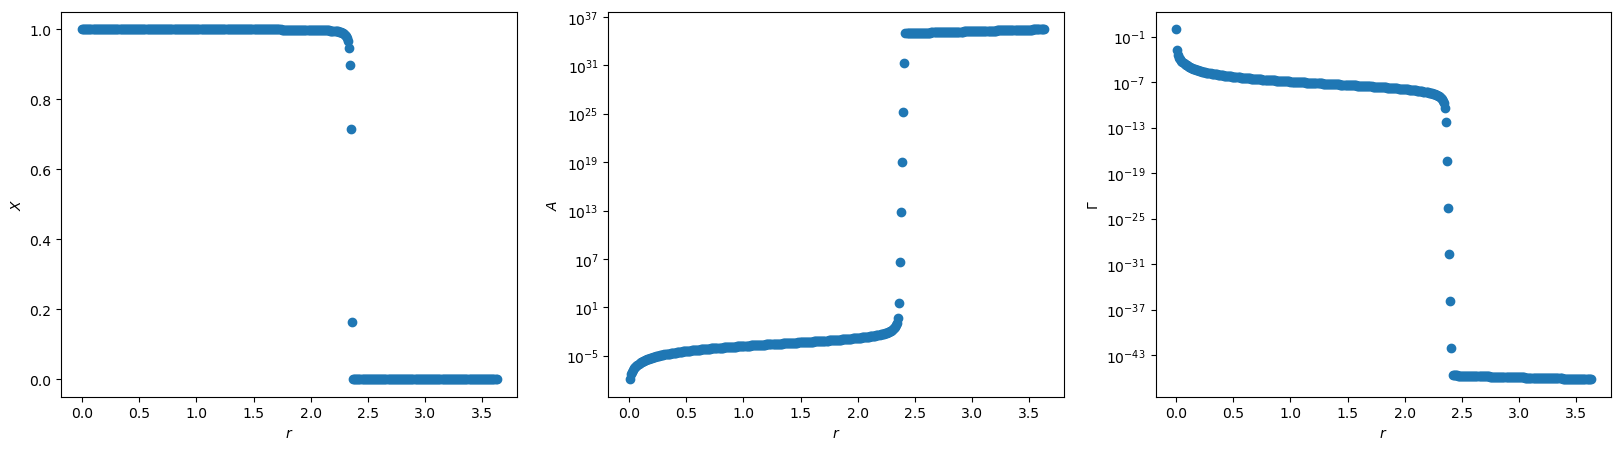

In [11]:
T = np.array([3.5, 3, 2.4, 2.2]) * 1e4 * u.K # array of temperatures for different spectral types 
Q = np.array([5e49, 7e48, 8e47, 1e46]) / u.s # photon flux from star
R_expected = np.array([6.8, 3.5, 1.7, 0.4]) # parsec
a = 1 # select which spectral type to consider
n_bins = 400 # bin number
r_s = 12 * R_sun # 12 solar radii for main sequence type 05 star http://astro.vaporia.com/start/o5.html

L_tot = h*nu_0*Q[a]
#L_nu = lambda nu: fake_delta(nu.to("Hz").value, nu_0.to("Hz").value, 1, L_tot) / u.Hz
L_nu = lambda nu: planck_law(nu, T[a]) * 4*np.pi*r_s**2

r_min = r_s.to("parsec").value
r_max = (1+3.64e-2)*R_expected[a]
r = np.linspace(r_min, r_max, n_bins) * u.parsec # radial bins

nu_bins = 10
nu = (np.linspace(13.6, 3000, nu_bins) * u.eV)/h

Q_integrated = integrate.trapezoid(L_nu(nu)/(h*nu), nu.to("Hz")) # find actual number of ionising photons for this case
print(Q[a], Q_integrated.to("1/s"))

Q_ratio = Q[a]/Q_integrated # renormalise luminosity so that the total number of ionising photons is the wanted value of Q

# Initialise starting values:
gamma_0 = sigma_nu(nu)*Q_ratio*L_nu(nu)/(h*nu) * 1/(4*np.pi*r_s**2)
gamma =  np.ones((n_bins, nu_bins)) * np.transpose(gamma_0)
gamma_1d = np.ones(n_bins) / u.s
X = np.ones(n_bins)
A = np.zeros(n_bins)
tau = np.ones((n_bins, nu_bins))

for i in range(len(r) - 1):
    dtau = (n_H*sigma_nu(nu.transpose())*(1 - X[i])*(r[i+1] - r[i])).decompose()
    tau[i+1] = tau[i] + dtau
    gamma[i+1] *= np.exp(-tau[i+1])*((r_s/r[i+1])**2)
    gamma_1d[i+1] = integrate.trapezoid(gamma[i+1], nu.to("Hz"))
    A[i+1] = n_H*alpha_B/gamma_1d[i+1]
    X[i+1] = ionisation_fraction(gamma_1d[i+1], n_H, alpha_B, debug = False)

plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
plt.scatter(r, X)
plt.xlabel(r"$r$")
plt.ylabel(r"$X$")

plt.subplot(1, 3, 2)
plt.scatter(r, A)
plt.xlabel(r"$r$")
plt.ylabel(r"$A$")
plt.yscale("log")

plt.subplot(1, 3, 3)
plt.scatter(r, gamma_1d)
plt.xlabel(r"$r$")
plt.ylabel(r"$\Gamma$")
plt.yscale("log")

In [12]:
print(min(r[X < 1e-1]))
expected_r = (3*Q[a]/(4*np.pi*(n_H**2)*alpha_B))**(1/3)
print(expected_r.to("parsec"))

2.3728106198905863 pc
3.245399446049575 pc
